In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV

# load the sales data set
sales_data = pd.read_csv('../../../Data/SalesData.csv')
sales_data.head()

sales_data = sales_data[sales_data['Category'] == 'Mesotherapy'] 


pharmacy_onehot = pd.get_dummies(sales_data['Pharmacy'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded2 = pd.concat([sales_data, pharmacy_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Product'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded3 = pd.concat([sales_data_encoded2, product_onehot], axis=1)

product_onehot = pd.get_dummies(sales_data['Location'])

# concatenate the one-hot encoded categories with the original data
sales_data_encoded = pd.concat([sales_data_encoded3, product_onehot], axis=1)

sales_data_encoded


,Date,Month,Quarter,Year,Qty,Product,Category,Pharmacy,Location,Pharmacy 1,...,"Brazil, USA, Blank, IE, Zimbabwe, Zurich",Ireland & Northern Ireland,London,"NorthEast, Midlands",NorthWest,Outside London M25,Outside London the rest,"Scotland, Newcastle",SouthEast,SouthWest
13,1-12-2015,12,4,2015,1,Injection 13,Mesotherapy,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
36,1-1-2016,1,1,2016,1,Injection 13,Mesotherapy,Pharmacy 2,NorthWest,0,...,0,0,0,0,1,0,0,0,0,0
37,1-1-2016,1,1,2016,1,Injection 13,Mesotherapy,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
38,1-1-2016,1,1,2016,1,Injection 13,Mesotherapy,Pharmacy 2,Outside London M25,0,...,0,0,0,0,0,1,0,0,0,0
78,1-2-2016,2,1,2016,1,Injection 13,Mesotherapy,Pharmacy 2,"Scotland, Newcastle",0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67191,1-3-2022,3,1,2022,1,Injection 13,Mesotherapy,Pharmacy 9,London,0,...,0,0,1,0,0,0,0,0,0,0
67428,1-3-2022,3,1,2022,1,Injection 13,Mesotherapy,Pharmacy 9,London,0,...,0,0,1,0,0,0,0,0,0,0
67441,1-3-2022,3,1,2022,1,Injection 13,Mesotherapy,Pharmacy 9,"Scotland, Newcastle",0,...,0,0,0,0,0,0,0,1,0,0
68019,1-3-2022,3,1,2022,1,Injection 13,Mesotherapy,Pharmacy 1,Outside London the rest,1,...,0,0,0,0,0,0,1,0,0,0


In [2]:
list(sales_data_encoded.columns)

['Date',
 'Month',
 'Quarter',
 'Year',
 'Qty',
 'Product',
 'Category',
 'Pharmacy',
 'Location',
 'Pharmacy 1',
 'Pharmacy 10',
 'Pharmacy 2',
 'Pharmacy 3',
 'Pharmacy 5',
 'Pharmacy 7',
 'Pharmacy 8',
 'Pharmacy 9',
 'Injection 12',
 'Injection 13',
 'Brazil, USA, Blank, IE, Zimbabwe, Zurich',
 'Ireland & Northern Ireland',
 'London',
 'NorthEast, Midlands',
 'NorthWest',
 'Outside London M25',
 'Outside London the rest',
 'Scotland, Newcastle',
 'SouthEast',
 'SouthWest']

In [3]:
# group the data by date and sum the quantities and category columns
sales_data_grouped = sales_data_encoded.groupby('Date').agg({
    'Qty': 'sum',
    'Pharmacy 1' : 'sum',
    'Pharmacy 2' : 'sum',
    'Pharmacy 3' : 'sum',
    'Pharmacy 5' : 'sum',
    'Pharmacy 7' : 'sum',
    'Pharmacy 8' : 'sum',
    'Pharmacy 9' : 'sum',
    'Pharmacy 10' : 'sum',
    'Injection 12' :'sum',
    'Injection 13' :'sum',
    'Brazil, USA, Blank, IE, Zimbabwe, Zurich' : 'sum',
    'Ireland & Northern Ireland' : 'sum',
    'London' : 'sum',
    'NorthEast, Midlands' : 'sum',
    'NorthWest' : 'sum',
    'Outside London M25' : 'sum',
    'Outside London the rest' : 'sum',
    'Scotland, Newcastle' : 'sum',
    'SouthEast' : 'sum',
    'SouthWest' : 'sum'
    					
})

# reset the index to make date a column again
sales_data_grouped = sales_data_grouped.reset_index()

# create lag features
sales_data_lagged = sales_data_grouped.copy()
for i in range(1, 8):
    sales_data_lagged[f'Qty_lag_{i}'] = sales_data_lagged['Qty'].shift(i)

# remove rows with missing values
sales_data_lagged.dropna(inplace=True)

# split the data into training and testing sets
train_size = int(len(sales_data_lagged) * 0.8)
train_data = sales_data_lagged[:train_size]
test_data = sales_data_lagged[train_size:]


In [4]:
# train a random forest model

# model = RandomForestRegressor(n_estimators=100, max_depth=5)
# model.fit(train_data.iloc[:, 2:], train_data['Qty'])

activation = ['identity', 'logistic', 'tanh', 'relu']
solver = ['lbfgs', 'sgd', 'adam']

random_grid_mlpr = {
    'activation' : activation,
    'solver' : solver
}

mlpr = MLPRegressor()
mlpr_random = RandomizedSearchCV(
    estimator=mlpr,
    param_distributions=random_grid_mlpr,
    n_iter=10,
    cv=5,
    verbose=5,
    random_state=0
)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .....activation=tanh, solver=lbfgs;, score=0.633 total time=   0.2s
[CV 2/5] END .....activation=tanh, solver=lbfgs;, score=0.574 total time=   0.0s
[CV 3/5] END .....activation=tanh, solver=lbfgs;, score=0.272 total time=   0.1s
[CV 4/5] END .....activation=tanh, solver=lbfgs;, score=0.836 total time=   0.0s
[CV 5/5] END .....activation=tanh, solver=lbfgs;, score=0.296 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END ......activation=relu, solver=adam;, score=0.507 total time=   0.1s
[CV 2/5] END ......activation=relu, solver=adam;, score=0.546 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END ......activation=relu, solver=adam;, score=0.269 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END ......activation=relu, solver=adam;, score=0.734 total time=   0.3s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END .....activation=relu, solver=adam;, score=-0.306 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END ...activation=logistic, solver=sgd;, score=0.497 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END ...activation=logistic, solver=sgd;, score=0.701 total time=   0.2s
[CV 3/5] END ...activation=logistic, solver=sgd;, score=0.224 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END ...activation=logistic, solver=sgd;, score=0.558 total time=   0.1s
[CV 5/5] END ..activation=logistic, solver=sgd;, score=-0.145 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END .......activation=relu, solver=sgd;, score=0.589 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END .......activation=relu, solver=sgd;, score=0.466 total time=   0.5s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END .......activation=relu, solver=sgd;, score=0.131 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END .......activation=relu, solver=sgd;, score=0.864 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END ......activation=relu, solver=sgd;, score=-1.137 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END ..activation=identity, solver=adam;, score=0.146 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END ..activation=identity, solver=adam;, score=0.549 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END ..activation=identity, solver=adam;, score=0.490 total time=   0.2s
[CV 4/5] END ..activation=identity, solver=adam;, score=0.452 total time=   0.0s
[CV 5/5] END .activation=identity, solver=adam;, score=-0.887 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END ......activation=tanh, solver=adam;, score=0.637 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END ......activation=tanh, solver=adam;, score=0.770 total time=   0.1s
[CV 3/5] END ......activation=tanh, solver=adam;, score=0.379 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END ......activation=tanh, solver=adam;, score=0.707 total time=   0.2s
[CV 5/5] END ......activation=tanh, solver=adam;, score=0.510 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END ...activation=identity, solver=sgd;, score=0.611 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END ...activation=identity, solver=sgd;, score=0.130 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/5] END ...activation=identity, solver=sgd;, score=0.385 total time=   0.4s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END ...activation=identity, solver=sgd;, score=0.796 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END ...activation=identity, solver=sgd;, score=0.488 total time=   0.3s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/5] END .......activation=tanh, solver=sgd;, score=0.627 total time=   0.2s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/5] END .......activation=tanh, solver=sgd;, score=0.641 total time=   0.2s
[CV 3/5] END ......activation=tanh, solver=sgd;, score=-0.067 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 4/5] END .......activation=tanh, solver=sgd;, score=0.675 total time=   0.1s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 5/5] END .......activation=tanh, solver=sgd;, score=0.178 total time=   0.1s
[CV 1/5] END .....activation=relu, solver=lbfgs;, score=0.493 total time=   0.1s
[CV 2/5] END .....activation=relu, solver=lbfgs;, score=0.295 total time=   0.0s
[CV 3/5] END .....activation=relu, solver=lbfgs;, score=0.126 total time=   0.1s
[CV 4/5] END .....activation=relu, solver=lbfgs;, score=0.803 total time=   0.2s
[CV 5/5] END ....activation=relu, solver=lbfgs;, score=-0.928 total time=   0.0s
[CV 1/5] END .activation=logistic, solver=lbfgs;, score=0.500 total time=   0.0s
[CV 2/5] END .activation=logistic, solver=lbfgs;, score=0.507 total time=   0.0s
[CV 3/5] END activation=logistic, solver=lbfgs;, score=-0.522 total time=   0.0s
[CV 4/5] END .activation=logistic, solver=lbfgs;, score=0.782 total time=   0.0s
[CV 5/5] END activation=logistic, solver=lbfgs;, score=-0.232 total time=   0.0s


c:\Users\galea\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


RMSE: 2.0467518202963437
[10.35634767  3.50431394  1.99565507  3.49002748  7.8906032   8.73088009
  5.51161601  2.02820255  3.77800378  8.08385131  5.4447584   6.59219661
  9.98583106]


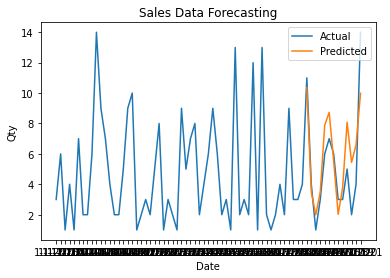

In [5]:
mlpr_random.fit(train_data.iloc[:, 2:], train_data['Qty'])


# make predictions for the test data
predictions = mlpr_random.predict(test_data.iloc[:, 2:])

# calculate the root mean squared error (RMSE) of the predictions
rmse = ((predictions - test_data['Qty']) ** 2).mean() ** 0.5
print('RMSE:', rmse)

print(predictions)

sales_data_grouped['predicted_quantity'] = pd.Series(predictions, index=test_data.index)

# plot the actual and predicted quantities against date
plt.plot(sales_data_grouped['Date'], sales_data_grouped['Qty'], label='Actual')
plt.plot(sales_data_grouped['Date'], sales_data_grouped['predicted_quantity'], label='Predicted')
plt.xlabel('Date')
plt.ylabel('Qty')
plt.title('Sales Data Forecasting')
plt.legend()
plt.show()

In [6]:
mlpr_random.best_params_

{'solver': 'adam', 'activation': 'tanh'}

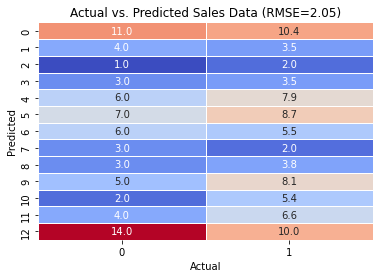

In [7]:
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_squared_error
import math

matrix_data = np.column_stack((test_data['Qty'].values, predictions))

# calculate the mean squared error
mse = mean_squared_error(test_data['Qty'], predictions)
rmse = math.sqrt(mse)

# plot the matrix using seaborn's heatmap function
sns.heatmap(matrix_data, annot=True, fmt='.1f', cmap='coolwarm', linewidths=.5, cbar=False)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title(f'Actual vs. Predicted Sales Data (RMSE={rmse:.2f})')
plt.show()